# Relax Challenge

Please see the link below for a short description of the raw data and the problem of interest:
https://github.com/jingzhaomirror/Springboard_Relax_Challenge/blob/master/relax_data_science_challenge.pdf

# 1. Import dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### import 'takehome_users.csv' as dataframe 'user'

In [2]:
user = pd.read_csv("takehome_users.csv", parse_dates=['creation_time'], encoding="ISO-8859-1")

In [3]:
user['last_session_creation_time'] = pd.to_datetime(user.last_session_creation_time, unit='s') # convert unix timestamp to datetime

In [4]:
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [5]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


Missing data are present in the 'last_session_creation_time' column and the 'invited_by_user_id' column. 

### import "takehome_user_engagement.csv" as dataframe 'engagement'

In [6]:
engagement = pd.read_csv("takehome_user_engagement.csv", parse_dates=['time_stamp'])

In [7]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


As shown, the 'engagement' dataframe is the usage summary table that keeps a log as an entry/row for each day that a user logged into the product.

# 2. data wrangling

To tackle the problem of predicting 'adopted user', the adopted users need to be identified first. 'adopted user' is defined as a user who has logged into the product on three separate days in at least one seven-day period, therefore the 'engagement' dataframe should be used to compute whether a user is an 'adopted user' or not. 

### prepare dataframes 'user' and 'engagement' for computing 'adopted user'

In [9]:
user.set_index('object_id',inplace=True) # set 'object_id' as the index of 'user'
user.index.name = 'user_id' # update the name of the index to be consistent with other dataframe 'engagement'
user['adopted_user'] = 0 # initiate 'adopted_user' column to 0 (non-adopted user)

In [10]:
# doublecheck that there is no duplicated entry for the same user on the same day in the 'engagement' dataframe
copy = engagement.copy()
copy['time_stamp'] = copy.time_stamp.dt.date
assert (copy.groupby(['user_id','time_stamp']).visited.count() == 1).all()

In [11]:
# compute 'adopted user'

# first sort the dataframe by 'user_id' first, then 'time_stamp'
engagement = engagement.sort_values(['user_id','time_stamp']) 

# then loop over the 'engagement' dataframe, and check if 'user_id' is the same as the following two entries,
# if so, check if their timestamps are within a seven-day period
for idx in engagement.index[:-2]:
    if engagement.loc[idx, 'user_id'] == engagement.loc[idx+2, 'user_id']:
        if (engagement.loc[idx+2,'time_stamp'] - engagement.loc[idx,'time_stamp']).days <= 7:
            user_id = engagement.loc[idx,'user_id']
            user.loc[user_id, 'adopted_user'] = 1

In [12]:
user.adopted_user.value_counts() # count adopted users vs non-adopted users

0    10344
1     1656
Name: adopted_user, dtype: int64

As shown, there are 1656 adopted users, 10344 non-adopted users out of a total of 12000 users. 

In [13]:
# take a look at the missing data in the 'last_session_creation_time' column
user[user.last_session_creation_time.isnull()].adopted_user.value_counts()

0    3177
Name: adopted_user, dtype: int64

As shown, all entries with missing data in the 'last_session_creation_time' and 'time_delta' columns correspond to 'non-adopted' users.

In [14]:
# fill in missing data for the 'invited_by_user_id' column by transforming the column
user['invited'] = user.invited_by_user_id.apply(lambda x: 0 if np.isnan(x) else 1)
user.invited.value_counts()

1    6417
0    5583
Name: invited, dtype: int64

In [15]:
user.head(2)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited
user_id,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1


# 3. EDA

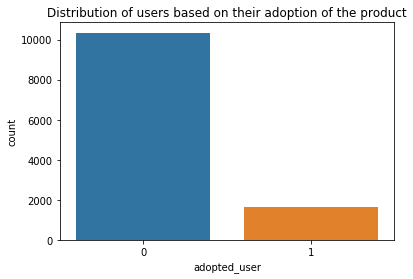

In [16]:
ax = sns.countplot(x="adopted_user", data=user)
ax.set_title('Distribution of users based on their adoption of the product');

As shown, the majority of the users are not adopted users (86.2%). 

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited
opted_in_to_mailing_list,1.000000,0.483529,0.003432,0.004699,0.008838,0.006934
enabled_for_marketing_drip,0.483529,1.000000,0.009275,0.003687,0.006578,0.002216
org_id,0.003432,0.009275,1.000000,-0.057780,0.066995,-0.018442
invited_by_user_id,0.004699,0.003687,-0.057780,1.000000,0.001185,NaN
adopted_user,0.008838,0.006578,0.066995,0.001185,1.000000,0.027831
invited,0.006934,0.002216,-0.018442,NaN,0.027831,1.000000


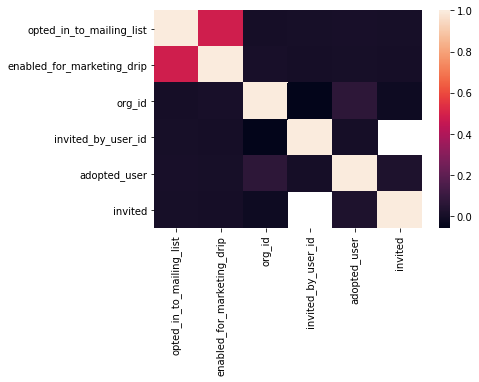

In [17]:
sns.heatmap(user.corr());
user.corr()

Look at the correlation matrix for a quick insight on the potential correlations between numeric columns. 
As shown, there is a weak correlation between user adoption ('adpoted_user') and their organization ('org_id'). 
In addition, 'opted_in_to_mailing_list' and 'enabled_for_marketing_drip' columns are related. 

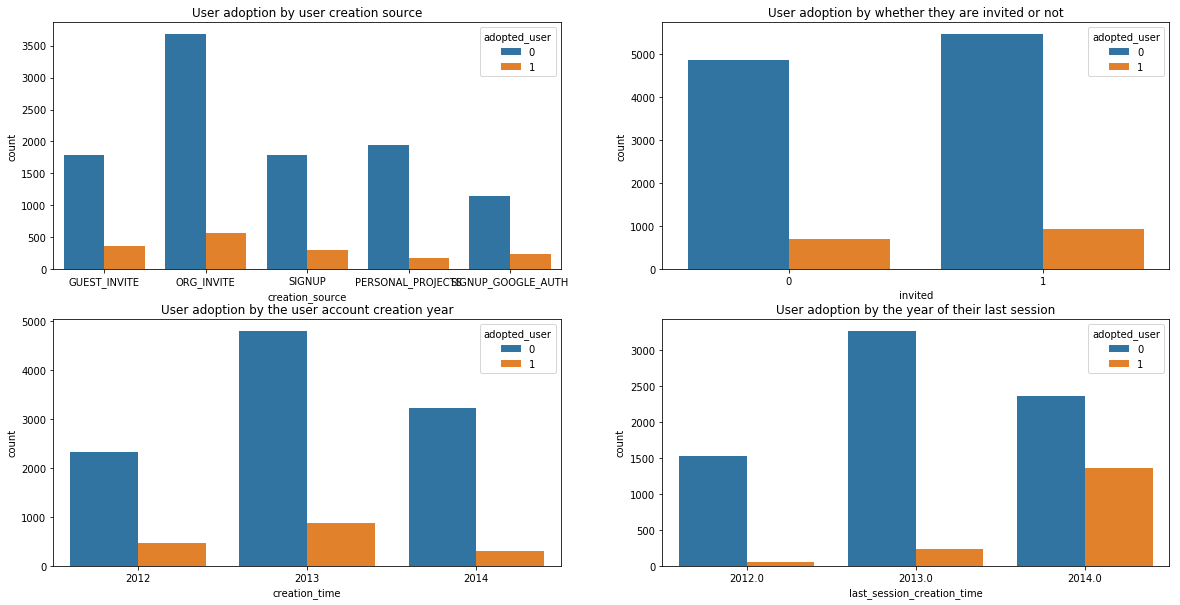

In [18]:
# look at categorical and datetime columns
plt.figure(figsize=(20,10));
ax1 = plt.subplot(2,2,1)
ax1 = sns.countplot(x='creation_source', hue='adopted_user', data=user, ax=ax1)
ax1.set_title('User adoption by user creation source');

ax2 = plt.subplot(2,2,2)
ax2 = sns.countplot(x=user.invited, hue=user.adopted_user, ax=ax2)
ax2.set_title('User adoption by whether they are invited or not');

ax3 = plt.subplot(2,2,3)
ax3 = sns.countplot(x=user.creation_time.dt.year, hue=user.adopted_user, ax=ax3)
ax3.set_title('User adoption by the user account creation year');

ax4 = plt.subplot(2,2,4)
ax4 = sns.countplot(x=user.last_session_creation_time.dt.year, hue=user.adopted_user, ax=ax4)
ax4.set_title('User adoption by the year of their last session');

As shown, there is a weak dependence between user adoption and user creation source, when users signed up via 'GUEST_INVITE' and 'ORG_INVITE' have higher ratio of adoption, whereas users signed up via 'PERSONAL_PROJECT' has the lowest ratio of adoption.

A strong correlation between user adoption and their activity timestamp is observed. In particular, users signed up earlier has higher adoption rate, and users with more recent activities on the product ('last_session_creation_time') have higher adoption rate. This suggests that the time difference between a user's account creation time and the user's last session time might be an importance indicator as well, where a user who signed up early and still has very recent activity is likely to be an adopted user. 

0.25      1.0
0.75      3.0
0.80      5.0
0.85     14.0
0.90     53.0
0.95    167.9
Name: visited, dtype: float64


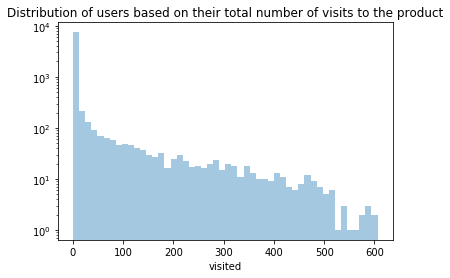

In [19]:
# look at 'engagement' dataframe
print(engagement.groupby('user_id').visited.count().quantile([0.25, 0.75, 0.8, 0.85, 0.9, 0.95]))

ax = sns.distplot(engagement.groupby('user_id').visited.count(),kde=False)
ax.set_yscale('log');
ax.set_title('Distribution of users based on their total number of visits to the product');

As shown, most of the users (> 75%) have visited the product no more than once, and these users are likely to be non-adpoted users. A feature out of users' visit activity can be very valuable.

# 4. Feature engineering
Based on the insights from the above EDA, two new features are introduced: 
1. 'time_delta': represents the time difference between a user's last session and their account creation date
2. 'total_visits': represents the total number of visits the user has to the product

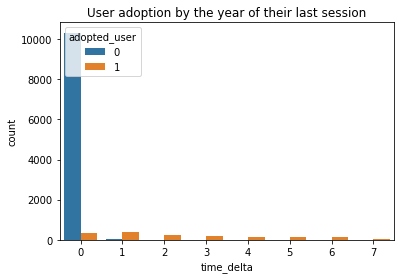

In [20]:
# add a new feature of 'time_delta', representing the time difference between a user's last session and their account creation date

user['time_delta'] = user.last_session_creation_time - user.creation_time
# fill in the missing data in the newly created 'time_delta' column (resulting from the missing data in the 'last_session_creation_time' column)
# fillna using the minimum value of the column, since all the missing data correspond to non-adopted user
user['time_delta'] = user.time_delta.fillna(user.time_delta.min())

ax = sns.countplot(x=user.time_delta.dt.days//100, hue=user.adopted_user)
ax.set_title('User adoption by the year of their last session');

As shown, the 'time_delta' strongly correlates to whether a user is an adopted user or not. Users with a time delta of less than 100 days are very likely to be non-adopted users, whereas users with a time delta of more than 200 days are all adopted users. 

In [21]:
# add a new feature of 'total_visits', representing the total number of visits the user has to the product

total_visits = engagement.groupby('user_id').visited.count()
total_visits.name = 'total_visits'

user2 = user.join(total_visits, how='left')
# fill in missing data with 0 since no entry in 'engagement' dataframe means no visit
user2['total_visits'] = user2.total_visits.fillna(0).astype('int') 

# understand correlation between 'total_visits' and 'adopted_user'
print(user2.total_visits.quantile([0.75, 0.8, 0.825, 0.85, 0.875, 0.9, 0.95]))
print(user2[user2.total_visits < 3].adopted_user.value_counts())
print(user2[user2.total_visits > 21].adopted_user.value_counts())

print(user2[user2.adopted_user == 1].total_visits.min(), user2[user2.adopted_user == 1].total_visits.max())
print(user2[user2.adopted_user == 0].total_visits.min(), user2[user2.adopted_user == 0].total_visits.max())

0.750      1.0
0.800      2.0
0.825      3.0
0.850      5.0
0.875      9.0
0.900     21.0
0.950    114.0
Name: total_visits, dtype: float64
0    9752
Name: adopted_user, dtype: int64
1    1198
Name: adopted_user, dtype: int64
3 606
0 15


As shown, the total number of visits strongly correlates to whether a user is an adopted user or not, therefore an important indicator of user adoption.<br> 


In addition, these two new features 'time_delta' and 'total_visits' will be important features to the machine learning models for predicting user adoption. 

# 5. Machine learning modeling

To predict user adoption of the product, three different classification algorithms are experimented: 
1. linear Logistic Regression classification algorithm
2. non-linear Support Vector Machine classification algorithm
3. ensembles of tree-based Random Forest classification algorithm 

Due to the fact there are only 1656 adopted users out of 12000 users (1656 positive vs. 10344 negative), this is considered as an imbalanced classification problem, f1_score and area_under_ROC_curve (roc_auc_score) are selected instead of the accuracy score for evaluating the performance of the classifiers.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [23]:
# prepare dataframe for modeling

# convert to cateogorical type
user2['adopted_user'] = user2.adopted_user.astype('category')
user2['opted_in_to_mailing_list'] = user2.opted_in_to_mailing_list.astype('category')
user2['enabled_for_marketing_drip'] = user2.enabled_for_marketing_drip.astype('category')
user2['invited'] = user2.invited.astype('category')

# user datetime.toordinal() to convert the 'creation_time' column (later is rescaled using sklearn standardscaler)
from datetime import datetime
user2['creation_time_ordinal'] = user2.creation_time.apply(datetime.toordinal)

# user timedelta.dt.days to convert 'time_delta' columns
user2['time_delta_day'] = user2.time_delta.dt.days

In [24]:
# extract features and target
X = user2.drop(['creation_time','name','email','last_session_creation_time','invited_by_user_id','adopted_user',\
              'time_delta'], axis=1)
y = user2.adopted_user

# convert categorical columns to dummy variables
X = pd.get_dummies(X, drop_first=True)  # convert categorical columns

In [25]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [26]:
# initiate the score table
index = ['LogisticRegression','SVC','RandomForestClassifier']
score_table = pd.DataFrame(index = index, columns= ['f1_score_train','auc_train','f1_score_test','auc_test'])

# define function for plotting the results
def compute_log_result(algo, pred_train, pred_test):
    """compute and log the performance for both training and test sets"""
    
    # compute the performance
    # since this classification problem is an imbalanced case (1656 positive vs. 10344 negative),
    # f1_score and area_under_ROC_curve (roc_auc_score) are used instead of accuracy for evaluating the performance of the models
    
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    auc_train = roc_auc_score(y_train, pred_train)
    auc_test = roc_auc_score(y_test, pred_test)
    
    # log the performance
    score_table.loc[algo,:] = f1_train, auc_train, f1_test, auc_test

In [27]:
# fit logistic regression model with default parameters

logit = Pipeline([('scaler', StandardScaler()),('logit',LogisticRegression())])
logit.fit(X_train, y_train)
pred_train = logit.predict(X_train)
pred_test = logit.predict(X_test)

# print features and their coefficients
feature_coef = pd.DataFrame({'feature':X_train.columns, 'coefficient':logit.named_steps.logit.coef_[0]})
print(feature_coef.sort_values('coefficient',ascending=False))

# logging of model performance
compute_log_result("LogisticRegression", pred_train, pred_test)

                               feature  coefficient
1                         total_visits     9.070598
3                       time_delta_day     6.293651
2                creation_time_ordinal     0.298292
0                               org_id     0.119693
8           opted_in_to_mailing_list_1     0.091815
10                           invited_1     0.019294
7   creation_source_SIGNUP_GOOGLE_AUTH     0.015262
5    creation_source_PERSONAL_PROJECTS    -0.010391
4           creation_source_ORG_INVITE    -0.019182
6               creation_source_SIGNUP    -0.027679
9         enabled_for_marketing_drip_1    -0.069189


In [28]:
# fit support vector machine model with default parameters

svc = Pipeline([('scaler', StandardScaler()),('svc', SVC())])
svc.fit(X_train, y_train)
pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

# logging of model performance
compute_log_result("SVC", pred_train, pred_test)

In [52]:
# fit random forest model with default parameters

rfc = Pipeline([('scaler', StandardScaler()),('rfc', RandomForestClassifier(class_weight='balanced'))]) # set class_weight='balanced' to adjust for the imbalanced classes
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

# print feature importance
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfc.named_steps.rfc.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

compute_log_result("RandomForestClassifier", pred_train, pred_test)

                               feature  importance
1                         total_visits    0.508997
3                       time_delta_day    0.446515
2                creation_time_ordinal    0.017991
0                               org_id    0.015902
5    creation_source_PERSONAL_PROJECTS    0.002816
6               creation_source_SIGNUP    0.001805
4           creation_source_ORG_INVITE    0.001657
7   creation_source_SIGNUP_GOOGLE_AUTH    0.001225
10                           invited_1    0.001218
8           opted_in_to_mailing_list_1    0.001104
9         enabled_for_marketing_drip_1    0.000768


In [53]:
score_table # print model performance with default parameters

,f1_score_train,auc_train,f1_score_test,auc_test
LogisticRegression,0.91926,0.937245,0.8975,0.928354
SVC,0.915673,0.930772,0.881748,0.910191
RandomForestClassifier,0.997983,0.997987,0.940741,0.957245


### Optimization of RandomForestClassifier
As shown, with the default parameters, RandomForestClassifier gives the best performance among the three, it also allows to adjust for the imbalanced classes by setting 'class_weight' parameter. Therefore, parameter tuning of the RandomForestClassifier model is further performed using gridsearch cross validation

In [61]:
# Grid search optimization of RandomForestClassifier
# Parameter tuning of rfc is desired, as the result from default parameters suggest overfitting to the training set

# Grid search of parameters n_estimators and max_features to improve RandomForestRegressor model
parameters = {'rfc__n_estimators': np.arange(20,90,5), 'rfc__max_features':['auto','sqrt','log2']}
# f1_score is used as the selection criteria since f1_score gives better sensitivity (wider range of score distribution) with imbalanced case
rfc_cv = GridSearchCV(rfc, parameters, scoring='f1', cv=5)
rfc_cv.fit(X_train, y_train)
print('Best parameters:', rfc_cv.best_params_)
print('Corresponding f1 score:', rfc_cv.best_score_)

Best parameters: {'rfc__max_features': 'log2', 'rfc__n_estimators': 55}
Corresponding f1 score: 0.950137980810749


In [66]:
# updated RandomForestClassification model with the optimized parameter
rfc = Pipeline([('scaler', StandardScaler()),('rfc', RandomForestClassifier(n_estimators=55, max_features='log2', class_weight='balanced'))])
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

compute_log_result("RandomForestClassifier", pred_train, pred_test)

In [67]:
# final results
print(score_table.loc['RandomForestClassifier'])

# feature importance ranking from the optimized RandomForestClassifier 
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfc.named_steps.rfc.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

f1_score_train           1
auc_train                1
f1_score_test     0.952612
auc_test          0.970143
Name: RandomForestClassifier, dtype: object
                               feature  importance
1                         total_visits    0.506764
3                       time_delta_day    0.437721
2                creation_time_ordinal    0.027143
0                               org_id    0.017002
5    creation_source_PERSONAL_PROJECTS    0.002668
8           opted_in_to_mailing_list_1    0.001841
4           creation_source_ORG_INVITE    0.001629
10                           invited_1    0.001378
9         enabled_for_marketing_drip_1    0.001358
6               creation_source_SIGNUP    0.001332
7   creation_source_SIGNUP_GOOGLE_AUTH    0.001165


As shown, the optimized RandomForestClassifier gives a pretty good f1 score and auc score. The feature ranking from the optimized classifier suggests that users' total number of visits to the product ('total_visits') and the time difference between a user's account creation and his last activity are the two critical factors indicating a user's adoption of the product, in good agreement with the EDA and feature engineering findings. 